# Comparison of the updated FY covariance matrices with the GLS technique

In this Notebook we want to update the variance matrices of the independent fission yields using the method of generalised least squares (GLS). It is an adjustment technique that states that the information on some prior system parameters can be improved with the addition of newknowledge for which relationships between data and parameters are established. These relationships, or constraints, must be linearised in the form:

$$
y - y_a = S \cdot (\theta -\theta_a) 
$$

where $\theta$ are the parameters of the system, $\theta_a$ the prior estimates of $\theta$, $y$ the responses of the constraining  equation,  $y_a$ the responses of the constraining equation to the prior  estimates $\theta_a$ and S are the sensitivity coefficients of the response $y – y_a$ to the parameters $\theta – \theta_a$. 

It is assumed that no correlations existed between the prior and the new information. Then, further information $\eta$ could be introduced in order to derive refined values for the parameters $\theta$,  with all the available uncertainty information properly incorporated into the formalism. The updating process is the following:

$$
\theta - \theta_a = V_a - S^T \cdot (S \cdot V_a \cdot S^T + V)^{-1} \cdot (\eta - y_a)
$$

$$
V_s = V_a - V_a \cdot S^T \cdot \left(S\cdot V_a \cdot S^T + V \right)^{-1} \cdot S \cdot V_a
$$

where $V_a$ is the covariance matrix of the prior estimates of the  parameters $\theta$, $V$ is the covariance matrix of the introduced data fitting the constraining system $\eta$, and $V_s$ is the updated  covariance matrix of the system parameters $\theta$.

A more complete overview of the the  followed GLS technique is described in https://doi.org/10.1016/j.anucene.2015.10.027

To perform this updating process we exploit the relationship between the independent fission yield and the $\textit{chain ﬁssion yield ch(A)}$, which in matrix form is:

$$
D^T \cdot IFY = Ch 
$$

The design matrix $S$ in this case is $D^T$, while the parameters $\theta$ are the independent fission yields $IFY$ and the response is the vector with the chain ﬁssion yields $Ch$ 

By using evaluated chain ﬁssion yields to modify independent ﬁssion yield data, we assume that we have a deeper knowledge on the ﬁrst. This is a consistent assumption since 
the chain ﬁssion yield and uncertainties are evaluated mostly directly from the measurements while the independent ﬁssion yields are not.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sps

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import sandy

### Get prior FY covariance matrix: $V_{x_{prior}}$

In [4]:
e = 0.0253
zam = 922350
tape = sandy.get_endf6_file('jeff_33','nfpy', zam)

In [5]:
nfpy = sandy.Fy.from_endf6(tape)

In [6]:
fy_stdev = nfpy.data.query(f"ZAM=={zam} & E=={e} & MT==454").set_index('ZAP').DFY
Vx_prior = sandy.CategoryCov.from_stdev(fy_stdev)
Vx_prior.data.head().T.head()

ZAP,10010,10020,10030,20030,20040
ZAP,,,,,
10010,8.69247e-12,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
10020,0.00000e+00,5.94823e-12,0.00000e+00,0.00000e+00,0.00000e+00
10030,0.00000e+00,0.00000e+00,3.43806e-11,0.00000e+00,0.00000e+00
20030,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
20040,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,6.61733e-09


### Get chain yields extra information

SANDY is able to retrieve the extra information for the evaluation of $V$ from the IAEA document [Evaluation and Compilation of Fission Product Yields 1993](https://www-nds.iaea.org/endf349/la-ur-94-3106.pdf) (page 18-29).

In [7]:
ch_info = sandy.fy.get_chain_yields()
e_ = 'thermal'
ch_info_std = ch_info.query(f"ZAM=={zam} & E =='{e_}'").set_index("A").DCHY
y_extra = ch_info.query(f"ZAM=={zam} & E =='{e_}'").set_index("A").CHY
Vy_extra = sandy.CategoryCov.from_stdev(ch_info_std).data
Vy_extra.head().T.head()

A,66,67,68,69,70
A,,,,,
66,5.33795e-20,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
67,0.00000e+00,6.89398e-19,0.00000e+00,0.00000e+00,0.00000e+00
68,0.00000e+00,0.00000e+00,5.24960e-18,0.00000e+00,0.00000e+00
69,0.00000e+00,0.00000e+00,0.00000e+00,2.52406e-17,0.00000e+00
70,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,6.93223e-17


### Get GLS update covariance matrix

The chain fission yield may be confused with the $\textit{mass ﬁssion yield M(A)}$, indeed the two can differ by a few percent. In SANDY is possible to perform the GLS update procedure, adding the above constrain, considering the chain yield or mass yield and the related design matrices. Both options are shown in this notebook.

- `mass yield` option

In [8]:
S_my = nfpy.get_mass_yield_sensitivity()
cov_massyield = nfpy.gls_update(zam, e, S_my, y_extra, Vy_extra=Vy_extra)[1]
cov_massyield.data.head().T.head()

ZAP,10010,10020,10030,20030,20040
ZAP,,,,,
10010,8.69247e-12,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
10020,0.00000e+00,5.94823e-12,0.00000e+00,0.00000e+00,0.00000e+00
10030,0.00000e+00,0.00000e+00,3.43806e-11,0.00000e+00,0.00000e+00
20030,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
20040,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,6.61733e-09


- `chain yield` option

In [9]:
tape_rdd = sandy.get_endf6_file('jeff_33', 'decay', 'all')
rdd = sandy.DecayData.from_endf6(tape_rdd)

In [10]:
S_cy = rdd.get_chain_yield_sensitivity()
cov_chainyield = nfpy.gls_update(zam, e, S_cy, y_extra, Vy_extra=Vy_extra)[1]
cov_chainyield.data.head().T.head()

ZAP,10010,10020,10030,20030,20040
ZAP,,,,,
10010,8.69247e-12,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
10020,0.00000e+00,5.94823e-12,0.00000e+00,0.00000e+00,0.00000e+00
10030,0.00000e+00,0.00000e+00,3.43806e-11,0.00000e+00,0.00000e+00
20030,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
20040,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,6.61733e-09


In [11]:
index_my = cov_massyield.data.index.values
index_my.sort()
index_cy = cov_chainyield.data.index.values
index_cy.sort()

In [12]:
cov_massyield = cov_massyield.data.reindex(index=index_my, columns=index_my)
cov_chainyield = cov_chainyield.data.reindex(index=index_cy, columns=index_cy)

In [13]:
zap = cov_massyield.index
nuclide = pd.Series(zap.values, index = zap, name="ZAP").to_frame()
nuclide['nuclide'] = nuclide.ZAP.apply(sandy.zam.zam2latex)
nuclide_index = nuclide.nuclide.values

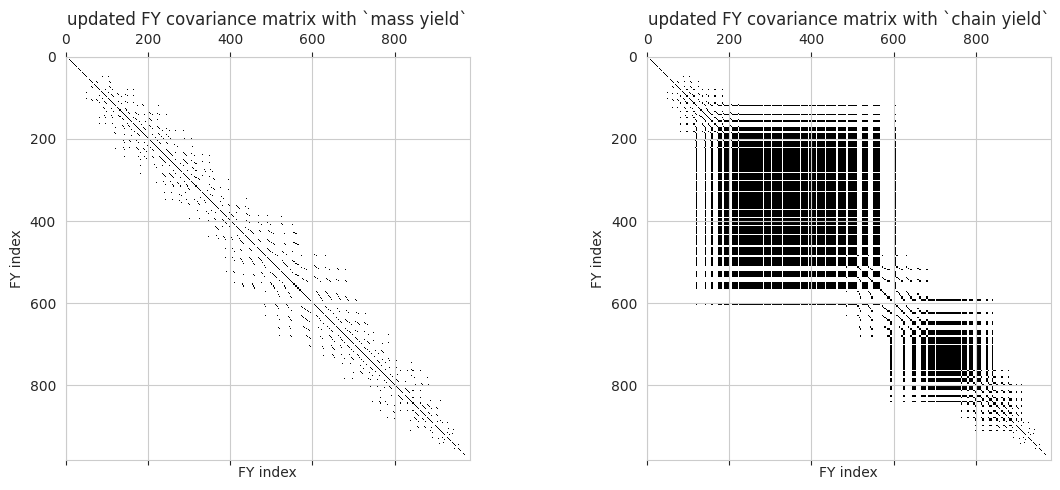

In [14]:
%%capture --no-display
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=100)
ax1, ax2 = axes

ax1.spy(cov_massyield)
ax1.set_title('updated FY covariance matrix with `mass yield`')
ax1.set_ylabel("FY index")
ax1.set_xlabel("FY index")

ax2.spy(cov_chainyield)
ax2.set_title('updated FY covariance matrix with `chain yield`')
ax2.set_ylabel("FY index")
ax2.set_xlabel("FY index")

fig.tight_layout()

"FY Index" is an index assigned to each fission product and is sorted by atomic number, mass number, and isomeric number in ascending order. Thus, for the 984 fission products, FY Index 0 has the lightest Z and A while FY Index 983 has the heaviest Z and A